# CNN + GolbalMaxPool
Try to improve CNN_264.

Change max pool to global max pool.

In [29]:
from datetime import datetime
print(datetime.now())

2023-03-26 20:33:20.918202


In [30]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

Found GPU at: /device:GPU:0
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [31]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=8 # 20 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC

Python 3.9.16
sklearn 1.2.2


In [32]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [33]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [34]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

## Model

In [35]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool1_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    drop1_layer = Dropout(0.5)
    cnn2_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool2_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    pool2_layer = GlobalMaxPooling1D()
    drop2_layer = Dropout(0.5)
    flat_layer = Flatten()
    #dens_layer = Dense(DCELLS,activation='relu')
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(pool1_layer)
    cnn.add(drop1_layer)
    cnn.add(cnn2_layer)
    cnn.add(pool2_layer)
    cnn.add(drop2_layer)
    cnn.add(flat_layer)
    cnn.add(output_layer)

    # Logits=False because sigmoid output is a probability in range [0.,1.]; see
    # https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class
    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return cnn

In [36]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-26 20:33:22.063923
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 4997, 4)           1028      
                                                                 
 conv1d_25 (Conv1D)          (None, 4990, 64)          2112      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 1246, 64)         0         
 1D)                                                             
                                                                 
 dropout_24 (Dropout)        (None, 1246, 64)          0         
                                                                 
 conv1d_26 (Conv1D)          (None, 1239, 64)          32832     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 64)               0         
 balMaxPooling1D)         

## Training

In [37]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [38]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            if gene_id in self.val_genes:
                self.val_ids.append(allids[t])
                self.val_seq.append(allseq[t])
                self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                self.train_ids.append(allids[t])
                self.train_seq.append(allseq[t])
                self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-03-26 20:33:22.275067
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.
2023-03-26 20:33:27.993119

Training # 1 1
2023-03-26 20:33:27.993266
2023-03-26 20:33:27.993311
Discriminator ZERO -1
Train 1:0 1800:1699 51.44%
Computed class weights: {0: 1.029723366686286, 1: 0.9719444444444445}
Valid 1:0 458:412 52.64%
FIT
2023-03-26 20:33:30.247744


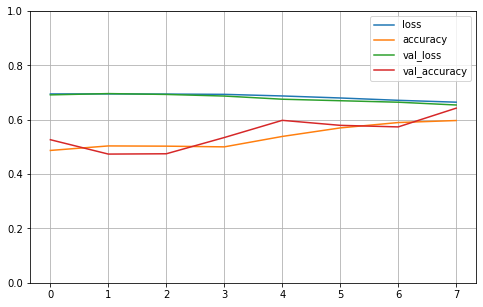


2023-03-26 20:33:52.311718

Testing # 1 1
2023-03-26 20:33:52.312036
2023-03-26 20:33:52.312078
PREDICT
2023-03-26 20:33:52.531718
Test 1:0 458:412 52.64%
Predict 1:0 445:425 51.15%
Test sizes (870, 4997) (870,)
Range of scores: 0.28547376 to 0.8630733
Score threshold 0.5
Confusion matrix
 [[263 149]
 [162 296]]
Normalized matrix
 [[0.30229885 0.17126437]
 [0.1862069  0.34022989]]


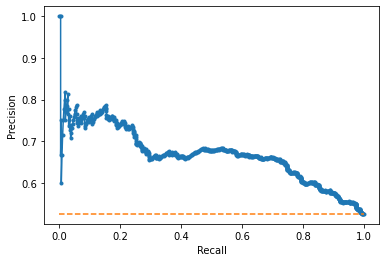

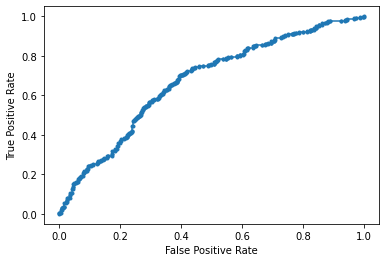

Accuracy: 64.25% Precision: 66.52% Recall: 64.63%
F1: 65.56% MCC: 0.2843
AUPRC: 66.86% AUROC: 67.19%
 accuracy [64.25287356321839]
 precision [66.51685393258427]
 recall [64.62882096069869]
 F1 [65.55924695459578]
 MCC [0.28431471317508245]
 AUPRC [66.8648169520463]
 AUROC [67.18955356764319]
2023-03-26 20:33:53.291059

Training # 1 2
2023-03-26 20:33:53.291825
2023-03-26 20:33:53.291872
Discriminator ZERO -1
Train 1:0 1816:1669 52.11%
Computed class weights: {0: 1.0440383463151588, 1: 0.9595264317180616}
Valid 1:0 442:442 50.00%
FIT
2023-03-26 20:33:54.461765


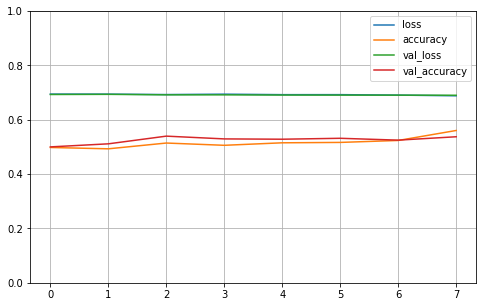


2023-03-26 20:34:09.647478

Testing # 1 2
2023-03-26 20:34:09.648872
2023-03-26 20:34:09.649193
PREDICT
2023-03-26 20:34:10.056321
Test 1:0 442:442 50.00%
Predict 1:0 575:309 65.05%
Test sizes (884, 4997) (884,)
Range of scores: 0.32833034 to 0.57519966
Score threshold 0.5
Confusion matrix
 [[171 271]
 [138 304]]
Normalized matrix
 [[0.19343891 0.30656109]
 [0.1561086  0.3438914 ]]


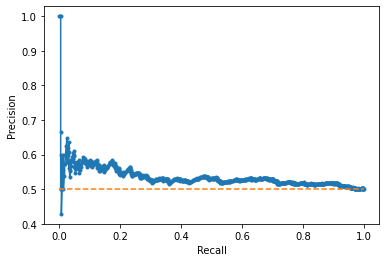

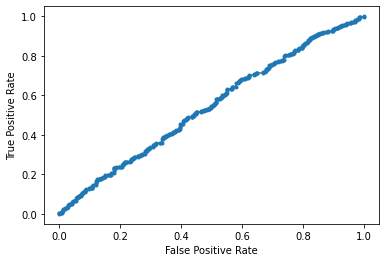

Accuracy: 53.73% Precision: 52.87% Recall: 68.78%
F1: 59.78% MCC: 0.0783
AUPRC: 53.55% AUROC: 54.30%
 accuracy [53.73303167420814]
 precision [52.8695652173913]
 recall [68.77828054298642]
 F1 [59.78367748279253]
 MCC [0.07828900577664778]
 AUPRC [53.54838306409333]
 AUROC [54.296083208779514]
2023-03-26 20:34:11.653270

Training # 1 3
2023-03-26 20:34:11.653394
2023-03-26 20:34:11.653434
Discriminator ZERO -1
Train 1:0 1816:1704 51.59%
Computed class weights: {0: 1.0328638497652582, 1: 0.9691629955947136}
Valid 1:0 442:407 52.06%
FIT
2023-03-26 20:34:13.838149


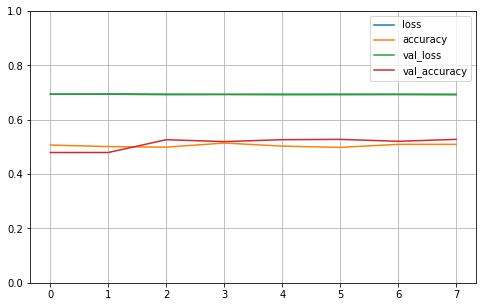


2023-03-26 20:34:28.480763

Testing # 1 3
2023-03-26 20:34:28.481137
2023-03-26 20:34:28.481188
PREDICT
2023-03-26 20:34:28.686688
Test 1:0 442:407 52.06%
Predict 1:0 831:18 97.88%
Test sizes (849, 4997) (849,)
Range of scores: 0.48744756 to 0.5298393
Score threshold 0.5
Confusion matrix
 [[ 12 395]
 [  6 436]]
Normalized matrix
 [[0.01413428 0.46525324]
 [0.00706714 0.51354535]]


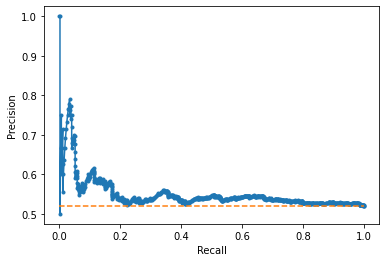

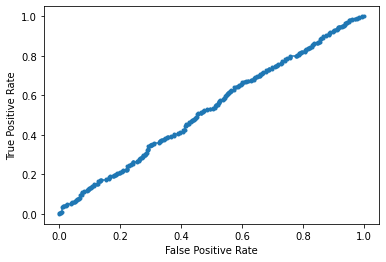

Accuracy: 52.77% Precision: 52.47% Recall: 98.64%
F1: 68.50% MCC: 0.0552
AUPRC: 55.07% AUROC: 52.96%
 accuracy [52.76796230859835]
 precision [52.46690734055355]
 recall [98.64253393665159]
 F1 [68.49960722702278]
 MCC [0.05517273659245778]
 AUPRC [55.070874499953405]
 AUROC [52.96063237239708]
2023-03-26 20:34:29.327797

Training # 1 4
2023-03-26 20:34:29.329369
2023-03-26 20:34:29.329704
Discriminator ZERO -1
Train 1:0 1799:1680 51.71%
Computed class weights: {0: 1.0354166666666667, 1: 0.9669260700389105}
Valid 1:0 459:431 51.57%
FIT
2023-03-26 20:34:30.509887


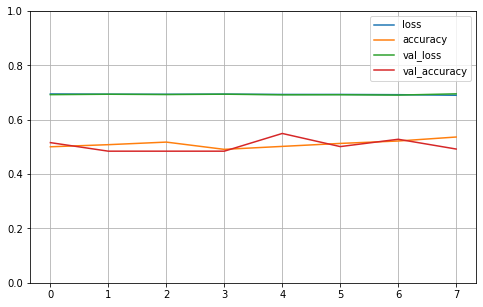


2023-03-26 20:34:52.301289

Testing # 1 4
2023-03-26 20:34:52.301377
2023-03-26 20:34:52.301411
PREDICT
2023-03-26 20:34:52.523678
Test 1:0 459:431 51.57%
Predict 1:0 47:843  5.28%
Test sizes (890, 4997) (890,)
Range of scores: 0.39056885 to 0.51461023
Score threshold 0.5
Confusion matrix
 [[411  20]
 [432  27]]
Normalized matrix
 [[0.46179775 0.02247191]
 [0.48539326 0.03033708]]


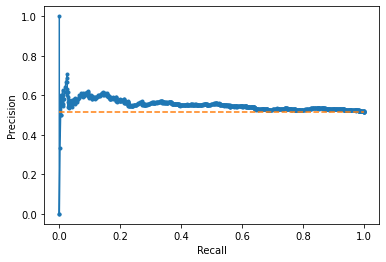

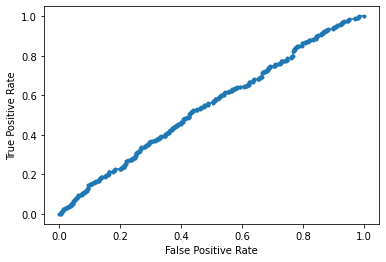

Accuracy: 49.21% Precision: 57.45% Recall: 5.88%
F1: 10.67% MCC: 0.0278
AUPRC: 55.14% AUROC: 54.61%
 accuracy [49.21348314606742]
 precision [57.446808510638306]
 recall [5.88235294117647]
 F1 [10.67193675889328]
 MCC [0.027752202920528615]
 AUPRC [55.139519284310666]
 AUROC [54.6052398788853]
2023-03-26 20:34:53.332002

Training # 1 5
2023-03-26 20:34:53.332626
2023-03-26 20:34:53.332671
Discriminator ZERO -1
Train 1:0 1801:1692 51.56%
Computed class weights: {0: 1.032210401891253, 1: 0.9697390338700722}
Valid 1:0 457:419 52.17%
FIT
2023-03-26 20:34:54.519914


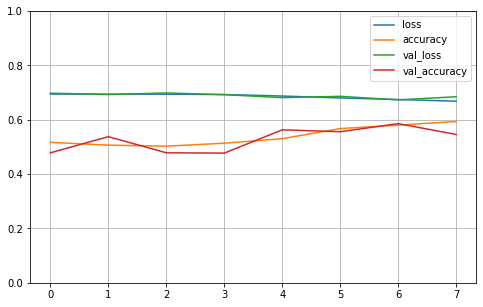


2023-03-26 20:35:09.452236

Testing # 1 5
2023-03-26 20:35:09.452642
2023-03-26 20:35:09.452674
PREDICT
2023-03-26 20:35:09.677972
Test 1:0 457:419 52.17%
Predict 1:0 813:63 92.81%
Test sizes (876, 4997) (876,)
Range of scores: 0.34759378 to 0.8166645
Score threshold 0.5
Confusion matrix
 [[ 42 377]
 [ 21 436]]
Normalized matrix
 [[0.04794521 0.4303653 ]
 [0.0239726  0.49771689]]


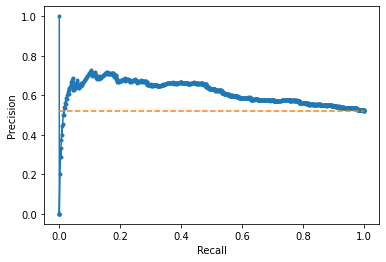

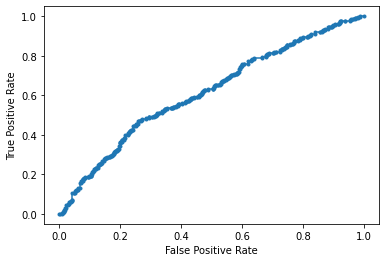

Accuracy: 54.57% Precision: 53.63% Recall: 95.40%
F1: 68.66% MCC: 0.1050
AUPRC: 61.38% AUROC: 61.47%
 accuracy [54.5662100456621]
 precision [53.62853628536285]
 recall [95.40481400437638]
 F1 [68.66141732283464]
 MCC [0.10496483674177735]
 AUPRC [61.3757308020986]
 AUROC [61.47386452061019]
2023-03-26 20:35:10.319678

Training # 2 1
2023-03-26 20:35:10.319847
2023-03-26 20:35:10.319899
Discriminator ZERO -1
Train 1:0 1786:1696 51.29%
Computed class weights: {0: 1.0265330188679245, 1: 0.9748040313549832}
Valid 1:0 472:415 53.21%
FIT
2023-03-26 20:35:11.497240


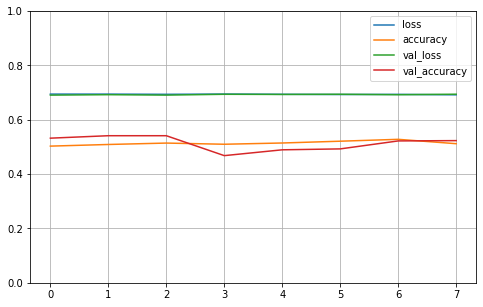


2023-03-26 20:35:26.163964

Testing # 2 1
2023-03-26 20:35:26.165622
2023-03-26 20:35:26.166016
PREDICT
2023-03-26 20:35:26.586188
Test 1:0 472:415 53.21%
Predict 1:0 445:442 50.17%
Test sizes (887, 4997) (887,)
Range of scores: 0.38602543 to 0.53183323
Score threshold 0.5
Confusion matrix
 [[217 198]
 [225 247]]
Normalized matrix
 [[0.24464487 0.22322435]
 [0.25366404 0.27846674]]


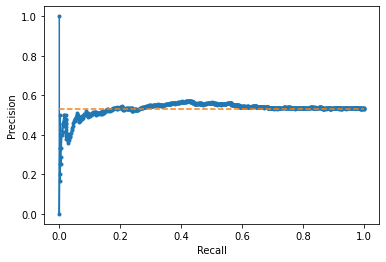

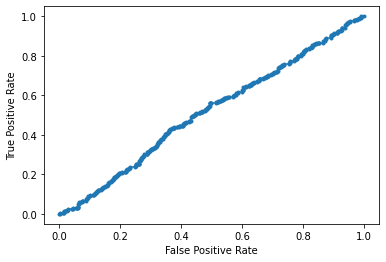

Accuracy: 52.31% Precision: 55.51% Recall: 52.33%
F1: 53.87% MCC: 0.0461
AUPRC: 53.25% AUROC: 51.72%
 accuracy [52.311161217587376]
 precision [55.50561797752809]
 recall [52.33050847457628]
 F1 [53.87131952017449]
 MCC [0.04610143038074666]
 AUPRC [53.247822939230396]
 AUROC [51.71686746987951]
2023-03-26 20:35:27.603374

Training # 2 2
2023-03-26 20:35:27.604919
2023-03-26 20:35:27.605305
Discriminator ZERO -1
Train 1:0 1806:1695 51.59%
Computed class weights: {0: 1.0327433628318583, 1: 0.9692691029900332}
Valid 1:0 452:416 52.07%
FIT
2023-03-26 20:35:29.720601


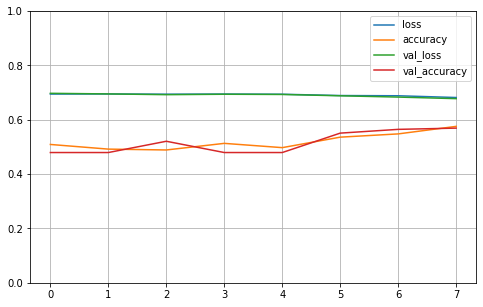


2023-03-26 20:35:51.482067

Testing # 2 2
2023-03-26 20:35:51.482163
2023-03-26 20:35:51.482198
PREDICT
2023-03-26 20:35:51.697411
Test 1:0 452:416 52.07%
Predict 1:0 228:640 26.27%
Test sizes (868, 4997) (868,)
Range of scores: 0.35400373 to 0.70568866
Score threshold 0.5
Confusion matrix
 [[341  75]
 [299 153]]
Normalized matrix
 [[0.39285714 0.08640553]
 [0.34447005 0.17626728]]


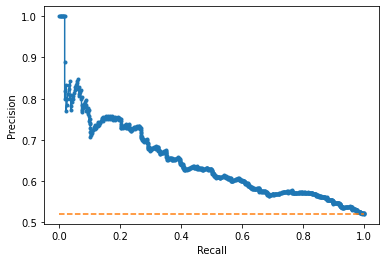

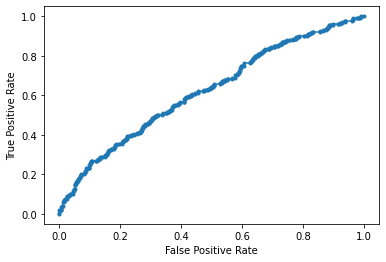

Accuracy: 56.91% Precision: 67.11% Recall: 33.85%
F1: 45.00% MCC: 0.1796
AUPRC: 64.58% AUROC: 62.31%
 accuracy [56.91244239631337]
 precision [67.10526315789474]
 recall [33.849557522123895]
 F1 [44.99999999999999]
 MCC [0.17959096315701661]
 AUPRC [64.57887553723987]
 AUROC [62.30588410483322]
2023-03-26 20:35:52.479016

Training # 2 3
2023-03-26 20:35:52.480736
2023-03-26 20:35:52.481174
Discriminator ZERO -1
Train 1:0 1805:1704 51.44%
Computed class weights: {0: 1.0296361502347418, 1: 0.97202216066482}
Valid 1:0 453:407 52.67%
FIT
2023-03-26 20:35:54.394098


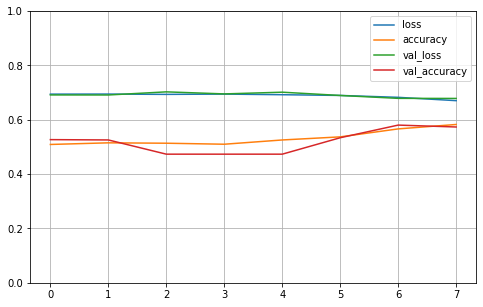


2023-03-26 20:36:17.067773

Testing # 2 3
2023-03-26 20:36:17.068347
2023-03-26 20:36:17.068394
PREDICT
2023-03-26 20:36:17.282991
Test 1:0 453:407 52.67%
Predict 1:0 232:628 26.98%
Test sizes (860, 4997) (860,)
Range of scores: 0.27071044 to 0.7373519
Score threshold 0.5
Confusion matrix
 [[334  73]
 [294 159]]
Normalized matrix
 [[0.38837209 0.08488372]
 [0.34186047 0.18488372]]


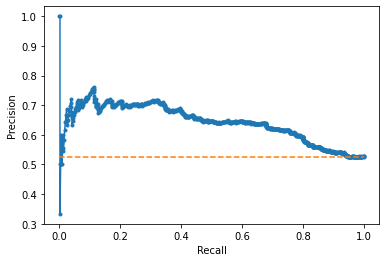

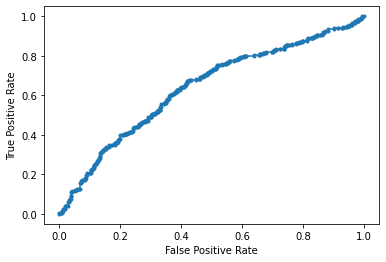

Accuracy: 57.33% Precision: 68.53% Recall: 35.10%
F1: 46.42% MCC: 0.1931
AUPRC: 64.21% AUROC: 63.87%
 accuracy [57.325581395348834]
 precision [68.53448275862068]
 recall [35.099337748344375]
 F1 [46.42335766423358]
 MCC [0.19307287157958142]
 AUPRC [64.20580898234788]
 AUROC [63.86633472726187]
2023-03-26 20:36:18.115414

Training # 2 4
2023-03-26 20:36:18.117030
2023-03-26 20:36:18.117087
Discriminator ZERO -1
Train 1:0 1826:1664 52.32%
Computed class weights: {0: 1.0486778846153846, 1: 0.9556407447973713}
Valid 1:0 432:447 49.15%
FIT
2023-03-26 20:36:19.301202


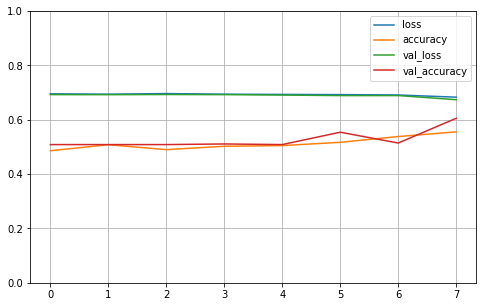


2023-03-26 20:36:41.562439

Testing # 2 4
2023-03-26 20:36:41.562530
2023-03-26 20:36:41.562563
PREDICT
2023-03-26 20:36:41.781512
Test 1:0 432:447 49.15%
Predict 1:0 293:586 33.33%
Test sizes (879, 4997) (879,)
Range of scores: 0.30348307 to 0.73155373
Score threshold 0.5
Confusion matrix
 [[343 104]
 [243 189]]
Normalized matrix
 [[0.39021615 0.11831627]
 [0.27645051 0.21501706]]


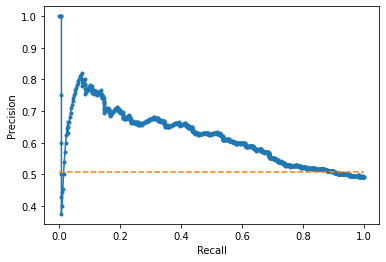

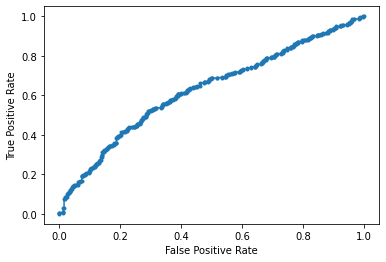

Accuracy: 60.52% Precision: 64.51% Recall: 43.75%
F1: 52.14% MCC: 0.2172
AUPRC: 61.73% AUROC: 62.67%
 accuracy [60.52332195676906]
 precision [64.50511945392492]
 recall [43.75]
 F1 [52.13793103448276]
 MCC [0.21723166738630958]
 AUPRC [61.72798669989115]
 AUROC [62.66700845140443]
2023-03-26 20:36:42.453422

Training # 2 5
2023-03-26 20:36:42.453548
2023-03-26 20:36:42.453586
Discriminator ZERO -1
Train 1:0 1809:1685 51.77%
Computed class weights: {0: 1.0367952522255193, 1: 0.9657269209508016}
Valid 1:0 449:426 51.31%
FIT
2023-03-26 20:36:43.650340


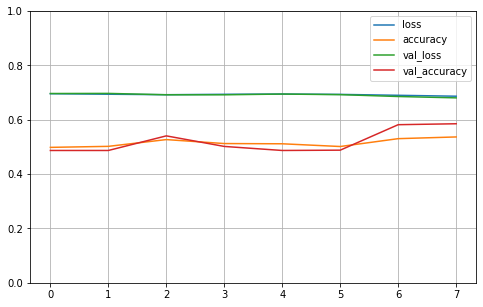


2023-03-26 20:37:05.416521

Testing # 2 5
2023-03-26 20:37:05.416964
2023-03-26 20:37:05.416998
PREDICT
2023-03-26 20:37:05.654921
Test 1:0 449:426 51.31%
Predict 1:0 640:235 73.14%
Test sizes (875, 4997) (875,)
Range of scores: 0.33655167 to 0.7239677
Score threshold 0.5
Confusion matrix
 [[149 277]
 [ 86 363]]
Normalized matrix
 [[0.17028571 0.31657143]
 [0.09828571 0.41485714]]


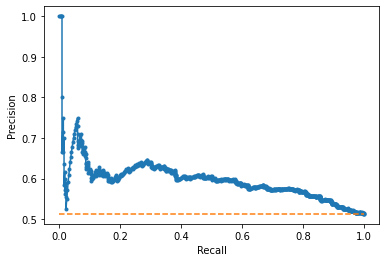

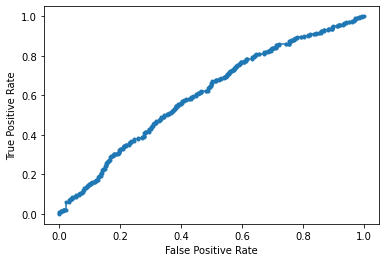

Accuracy: 58.51% Precision: 56.72% Recall: 80.85%
F1: 66.67% MCC: 0.1784
AUPRC: 59.76% AUROC: 60.63%
 accuracy [58.51428571428572]
 precision [56.71874999999999]
 recall [80.84632516703786]
 F1 [66.66666666666666]
 MCC [0.17843859296922993]
 AUPRC [59.76318294918078]
 AUROC [60.63186841912649]
2023-03-26 20:37:06.296348


In [39]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_sequence(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_sequence(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [40]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 56.01% std 4.41
 precision mean 59.53% std 6.41
 recall mean 57.92% std 29.42
 F1 mean 53.73% std 17.55
 MCC mean 0.14% std 0.09
 AUPRC mean 59.55% std 4.99
 AUROC mean 59.17% std 5.32
 accuracy [[64.25287356321839], [53.73303167420814], [52.76796230859835], [49.21348314606742], [54.5662100456621], [52.311161217587376], [56.91244239631337], [57.325581395348834], [60.52332195676906], [58.51428571428572]]
 precision [[66.51685393258427], [52.8695652173913], [52.46690734055355], [57.446808510638306], [53.62853628536285], [55.50561797752809], [67.10526315789474], [68.53448275862068], [64.50511945392492], [56.71874999999999]]
 recall [[64.62882096069869], [68.77828054298642], [98.64253393665159], [5.88235294117647], [95.40481400437638], [52.33050847457628], [33.849557522123895], [35.099337748344375], [43.75], [80.84632516703786]]
 F1 [[65.55924695459578], [59.78367748279253], [68.49960722702278], [10.67193675889328], [68.66141732283464], [53.87131952017449], [44.9999999999999